# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime

from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer
from collections import deque

## Przydatne funkcje


In [2]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(4, 1), (2, 2), (3, 5), (4, 7), (6, 6), (3, 9), (6, 8), (9, 10), (7, 4), (4, 3), (5, 0)]
polygon_example_colors = [4,4,4,4,3,0,2,0,4,4,1]
polygon_example_tri = [(2, 5),(2, 6),(6, 3), (2, 4),(0, 2)]

In [3]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [4]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [5]:
def createdTriPoints(polygon,tri):
    """
    Funkcja tworzy tablice polaczen wlasciwych -> nalezy uzywac po zastosowaniu algortymu wyszukiwania triangulizacji
    """
    newTri = []
    for connect in tri:
        firstPoint = connect[0]
        secondPoint = connect[1]
        newTri.append((polygon[firstPoint],polygon[secondPoint]))
    return newTri

In [6]:
def draw_polygon_tri(polygon,tri):

    vis = Visualizer()
    correctTri = createdTriPoints(polygon,tri)
    vis.add_polygon(polygon, fill=False)
    vis.add_point(polygon)
    vis.add_line_segment(correctTri, color='red')
    vis.show()


In [7]:
def load_clicked_tests():
    with open('polygons.pkl', 'rb') as file:
        polygons = pickle.load(file)
    return polygons

In [8]:
#print(load_clicked_tests())

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

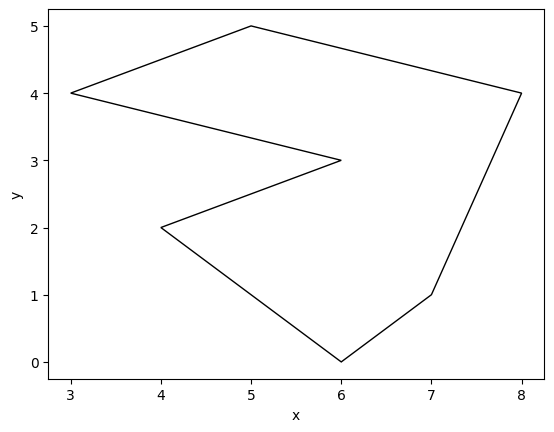

In [9]:
draw_polygon(polygon_example_1)

Do tego celu wygeneruj wielokąt.

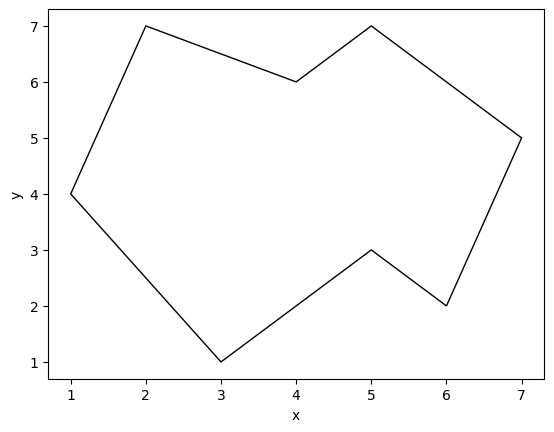

In [10]:
#polygon = [(3,4),(1,2),(5,9),(0,32)] #your polygon
next_polygon = [(1,4),(3,1),(5,3),(6,2),(7,5),(5,7),(4,6),(2,7)]
draw_polygon(next_polygon)

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [11]:
def getBiggestOne(polygon): #funkcja zwraca najwiekszy wierzcholek naszego wielokata wzgledem OY
    n=len(polygon)
    biggestOne = (float('inf'),float('-inf'))
    idBiggestOne = -1
    for i in range(n):
        if polygon[i][1] > biggestOne[1] or polygon[i][1] == biggestOne[1] and polygon[i][0] > biggestOne[0]:
            biggestOne,idBiggestOne = polygon[i],i
    return biggestOne,idBiggestOne

In [12]:
def getSmallestOne(polygon): #funkcja zwraca najmniejszy wierzcholek naszego wielokata wzledem OY
    n=len(polygon)
    smallestOne = (float('-inf'),float('inf'))
    idSmallestOne = -1
    for i in range(n):
        if (polygon[i][1] < smallestOne[1]) or (polygon[i][1] == smallestOne[1] and polygon[i][0] > smallestOne[0]):
            smallestOne,idSmallestOne = polygon[i],i
    return smallestOne,idSmallestOne

In [13]:
def moveRight(polygon,idAct):
    n=len(polygon)
    if idAct + 1 < n: return idAct+1
    else: return 0

In [14]:
def moveLeft(polygon,idAct):
    n=len(polygon)
    if idAct - 1 >= 0: return idAct-1
    else: return n - 1

In [15]:
def is_y_monotonic(polygon): #O(n)
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    biggestOne,idBiggestOne = getBiggestOne(polygon)
    smallestOne,idSmallestOne = getSmallestOne(polygon)

    pointerPrev = idBiggestOne
    pointerNext = moveRight(polygon, pointerPrev)

    while pointerNext != idSmallestOne:
        if polygon[pointerNext][1] < polygon[pointerPrev][1]:
            pointerPrev = pointerNext
            pointerNext = moveRight(polygon, pointerNext)
        else: return False

    pointerPrev = idBiggestOne
    pointerNext = moveLeft(polygon, pointerPrev)

    while pointerNext != idSmallestOne:
        if polygon[pointerNext][1] < polygon[pointerPrev][1]:
            pointerPrev = pointerNext
            pointerNext = moveLeft(polygon, pointerNext)
        else: return False

    return True

Przeprowadź test poprawności powyższej funkcji.

In [16]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.122s


Sprawdź monotoniczność swojego wielokątu.

***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których wielokąt zaczyna się monotoniczny spadek 
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji. 
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny. 
- prawdiłowy, pozostałe przypadki, jeden sąsiad powyżej drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

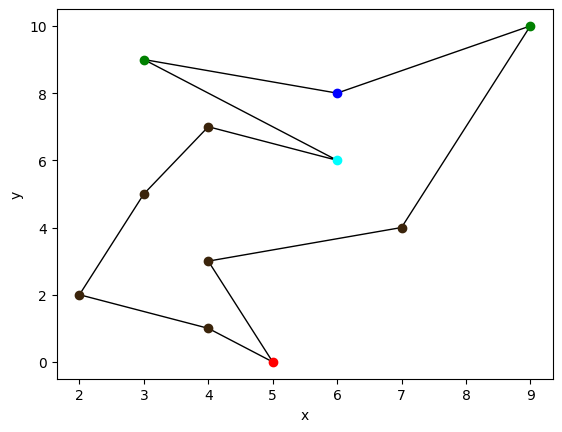

In [17]:
draw_polygon_colors(polygon_example_2,polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [18]:
def mat_det_2x2(a, b, c):
    a_x=a[0]
    a_y=a[1]
    b_x=b[0]
    b_y=b[1]
    c_x=c[0]
    c_y=c[1]
    return (a_x-c_x)*(b_y-c_y)-(a_y-c_y)*(b_x-c_x)

In [19]:
def color_vertex(polygon): #O(n)
    """
    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """



    n = len(polygon)
    T = [-1 for _ in range(n)]

    biggestOne,idBiggestOne = getBiggestOne(polygon)
    smallestOne,idSmallestOne = getSmallestOne(polygon)

    pointerPrePrev = idBiggestOne
    pointerPrev = moveRight(polygon,idBiggestOne)
    pointerNext = moveRight(polygon, pointerPrev)

    while pointerNext != moveRight(polygon,idSmallestOne): #poruszam sie po lewym lancuchu - przeciwnie do ruchu wskazowek zegara
        point1 = polygon[pointerPrePrev]
        point2 = polygon[pointerPrev]
        point3 = polygon[pointerNext]
        if mat_det_2x2(point1,point2,point3) < 0:
            if point1[1] > point2[1] and point3[1] > point2[1]:
                T[pointerPrev] = 2
            elif point1[1] < point2[1] and point3[1] < point2[1]:
                T[pointerPrev] = 3
        elif mat_det_2x2(point1,point2,point3) > 0:
            if point1[1] > point2[1] and point3[1] > point2[1]:
                T[pointerPrev] = 1
            elif point1[1] < point2[1] and point3[1] < point2[1]:
                T[pointerPrev] = 0

        pointerPrePrev = pointerPrev
        pointerPrev = pointerNext
        pointerNext = moveRight(polygon, pointerNext)

    pointerPrePrev = idBiggestOne
    pointerPrev = moveLeft(polygon,idBiggestOne)
    pointerNext = moveLeft(polygon, pointerPrev)

    while pointerNext != moveLeft(polygon,idSmallestOne): #poruszam sie po prawym lanchu - zgodnie z ruchem wskazowek zegara
        point1 = polygon[pointerPrePrev]
        point2 = polygon[pointerPrev]
        point3 = polygon[pointerNext]
        if mat_det_2x2(point1,point2,point3) > 0:
            if point1[1] > point2[1] and point3[1] > point2[1]:
                T[pointerPrev] = 2
            elif point1[1] < point2[1] and point3[1] < point2[1]:
                T[pointerPrev] = 3
        elif mat_det_2x2(point1,point2,point3) < 0:
            if point1[1] > point2[1] and point3[1] > point2[1]:
                T[pointerPrev] = 1
            elif point1[1] < point2[1] and point3[1] < point2[1]:
                T[pointerPrev] = 0

        pointerPrePrev = pointerPrev
        pointerPrev = pointerNext
        pointerNext = moveLeft(polygon, pointerNext)

    pointerMid = idBiggestOne
    pointerRight = moveLeft(polygon,pointerMid)
    pointerLeft = moveRight(polygon, pointerMid)

    if mat_det_2x2(polygon[pointerLeft],polygon[pointerMid],polygon[pointerRight]) < 0 and\
            polygon[pointerMid][1] > polygon[pointerRight][1] and polygon[pointerMid][1] > polygon[pointerLeft][1]:
        T[pointerMid] = 0

    pointerMid = idSmallestOne
    pointerLeft = moveLeft(polygon,pointerMid)
    pointerRight = moveRight(polygon, pointerMid)

    if mat_det_2x2(polygon[pointerLeft],polygon[pointerMid],polygon[pointerRight]) > 0:
        if polygon[pointerMid][1] < polygon[pointerRight][1] and polygon[pointerMid][1] < polygon[pointerLeft][1]:
            T[pointerMid] = 1

    for i in range(n):
        if T[i] == -1: T[i] = 4

    draw_polygon_colors(polygon,T)
    return T

Przeprowadź test poprawności powyższej funkcji.

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.309s


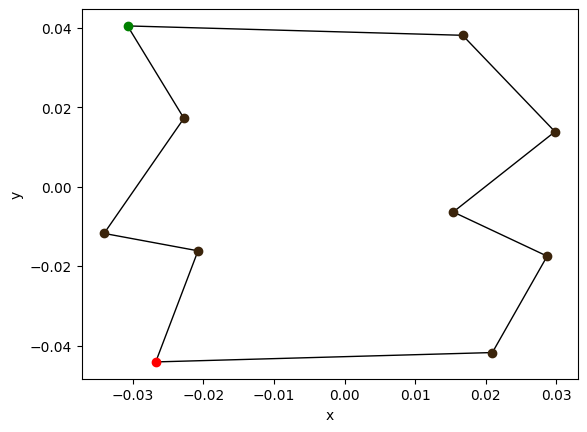

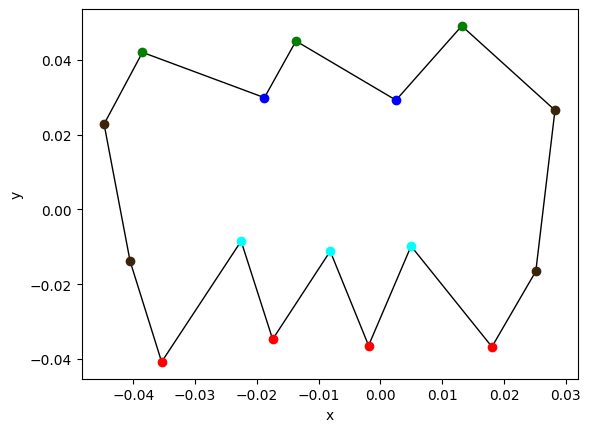

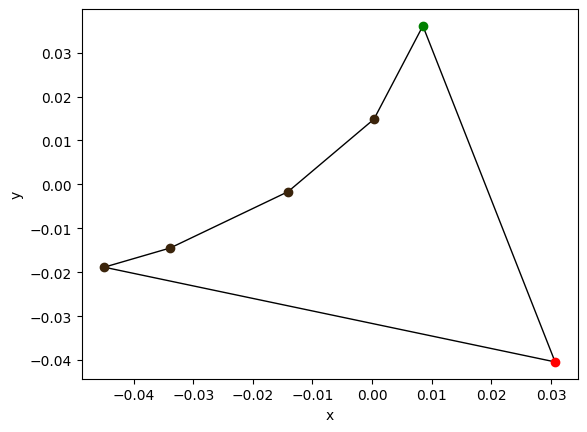

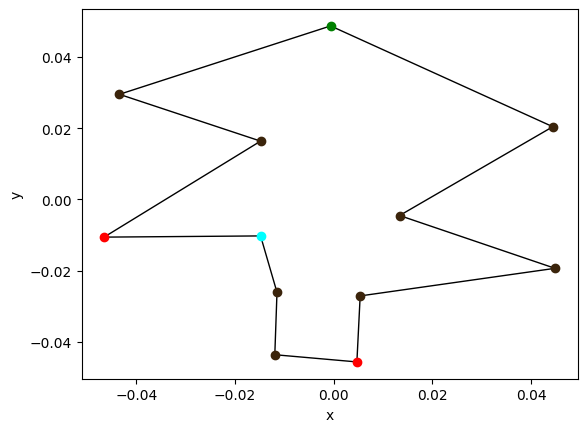

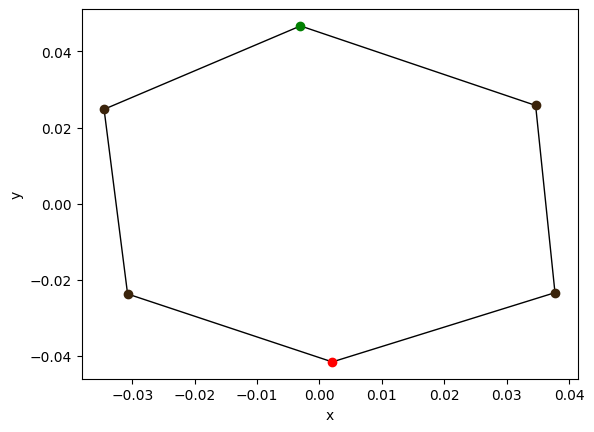

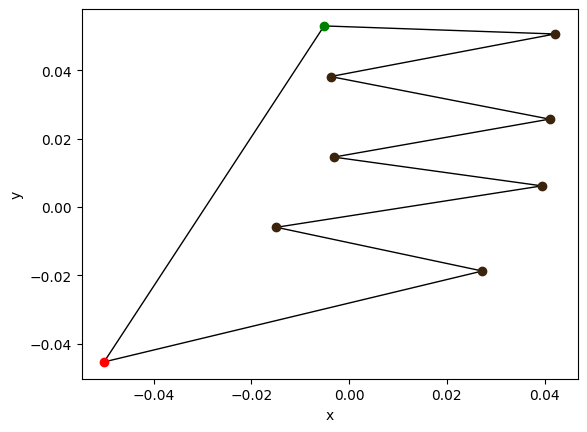

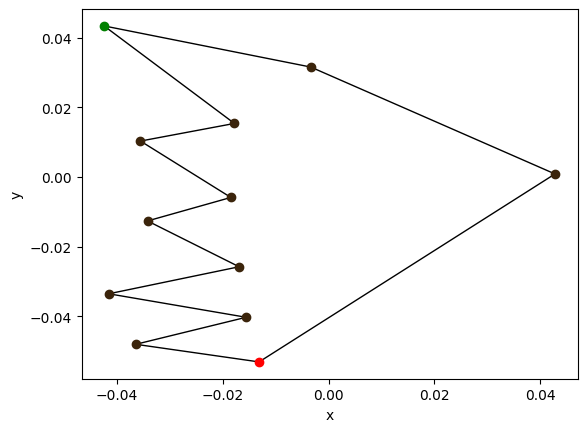

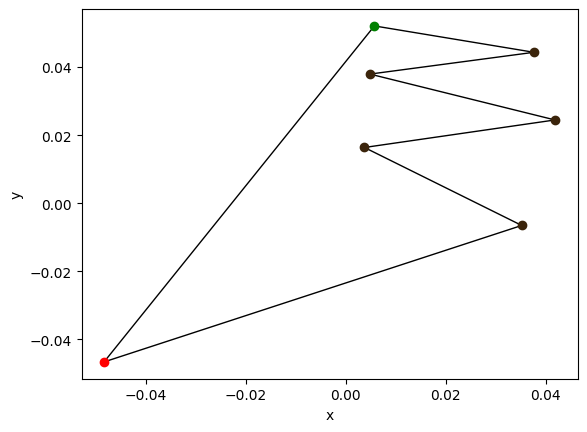

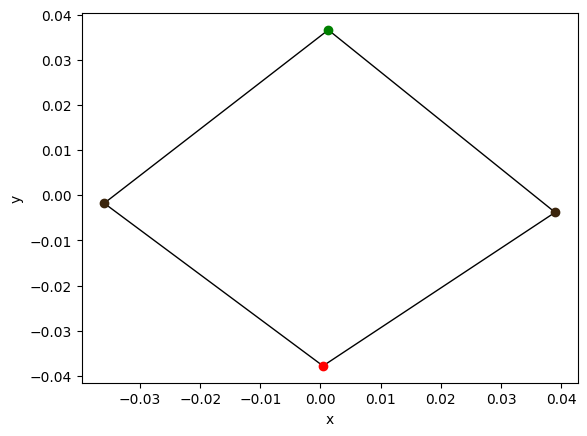

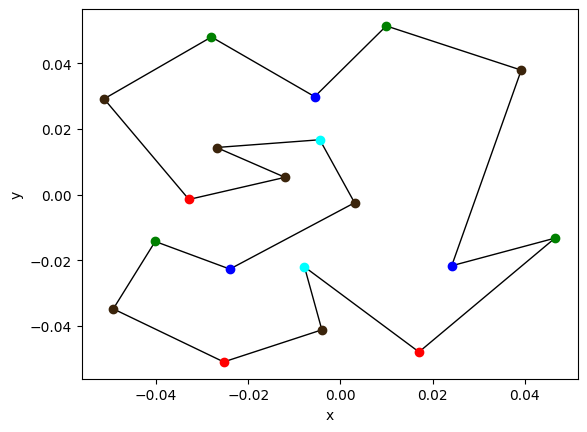

In [20]:
Test().runtest(2, color_vertex)

Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

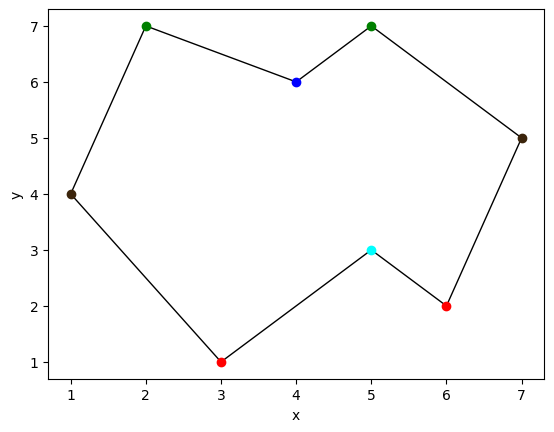

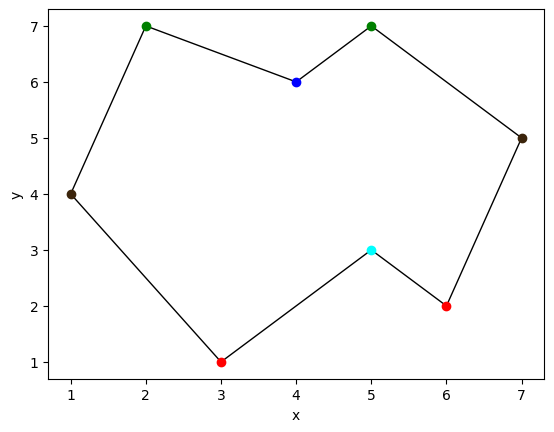

In [21]:
colors = color_vertex(next_polygon)
draw_polygon_colors(next_polygon,colors)

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

### Przykładowy wielokąt podzielony na trójkąty.

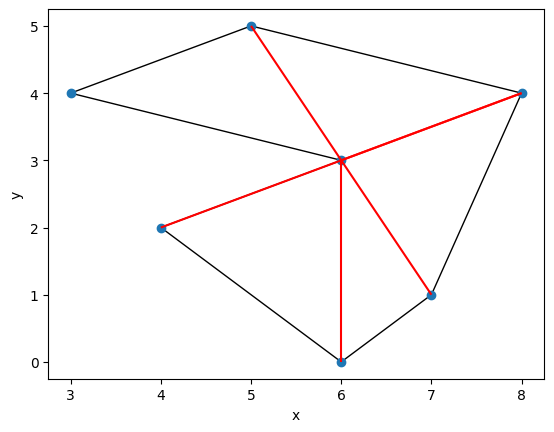

In [22]:
draw_polygon_tri(polygon_example_1,polygon_example_tri)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [23]:
def createSides(polygon):
    """
    Funkcja tworzy dwa slowniki, ktore odpowiadaja wierzcholka ktore znajduja sie na odpowiednich pozycjach.
    :param polygon: tablica krotek punktow na plaszczyznie
    :return: prawy i lewy łańcuch wielokąta
    """
    biggestOne,idBiggestOne = getBiggestOne(polygon)
    smallestOne,idSmallestOne = getSmallestOne(polygon)
    pointer = idBiggestOne

    leftSide = {} #jako klucz bede przechowywal dany punkt, a wartosc klucz ktory pomoze mi znalezc gdzie konkretnie sie znajduje ten element
    rightSide = {}

    while pointer != idSmallestOne:
        point = polygon[pointer]
        leftSide[point] = pointer
        pointer = moveRight(polygon,pointer)

    leftSide[polygon[idSmallestOne]] = idSmallestOne
    pointer = moveLeft(polygon,idBiggestOne)

    while pointer != idSmallestOne:
        point = polygon[pointer]
        rightSide[point] = pointer
        pointer = moveLeft(polygon,pointer)

    return leftSide, rightSide

In [24]:
def checkEdge(polygon,idA,idB):
    """
    Funkcja sprawdza czy miedzy wierzchołkami istnieje już krawędź, czy też nie
    :param polygon: tablica krotek punktow na plaszczyznie
    :param idA: indeks pierwszego wierzcholka
    :param idB: indeks drugiego wierzcholka
    :return: wartość True/False zalezenie czy istnieje krawedz pomiedzy tymi wierzcholkami, czy tez ona nie istnieje
    """
    pointRightFromA = moveRight(polygon, idA)
    pointLeftFromA = moveLeft(polygon, idA)
    if pointRightFromA == idB or pointLeftFromA == idB:
        return True
    return False

In [25]:
def checkLeftInside(polygon,idA,idB,idC):
    """
    Funkcja sprawdza czy krawedz miedzy wierzchokami idA, oraz idB, jest wewnatrz wielokąta jesli jestesmy w lewym łańuchu
    :param polygon: tablica krotek punktow na plaszczyznie
    :param idA: indeks pierwszego wierzcholka
    :param idB: indeks drugiego wierzcholka
    :param idB: indeks trzeciego wierzcholka
    :return: wartość True/False zalezenie czy istnieje krawedz pomiedzy tymi wierzcholkami, czy tez ona nie istnieje
    """
    pointA = polygon[idA]
    pointB = polygon[idB]
    pointC = polygon[idC]
    matDet2x2 = mat_det_2x2(pointA,pointB,pointC)
    if matDet2x2 >= 0: return False
    return True

In [26]:
def checkRightInside(polygon,idA,idB,idC):
    """
    Funkcja sprawdza czy krawedz miedzy wierzchokami idA, oraz idB, jest wewnatrz wielokąta jesli jestesmy w prawym łańuchu
    :param polygon: tablica krotek punktow na plaszczyznie
    :param idA: indeks pierwszego wierzcholka
    :param idB: indeks drugiego wierzcholka
    :param idB: indeks trzeciego wierzcholka
    :return: wartość True/False zalezenie czy istnieje krawedz pomiedzy tymi wierzcholkami, czy tez ona nie istnieje
    """
    pointA = polygon[idA]
    pointB = polygon[idB]
    pointC = polygon[idC]
    matDet2x2 = mat_det_2x2(pointA,pointB,pointC)
    if matDet2x2 <= 0: return False
    return True

In [27]:
def triangulation(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego -> wzdluz osi OY.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    n = len(polygon)
    D = []
    points = []

    for i in range(n):
        points.append((polygon[i],i))

    points.sort(key = lambda point:point[0][1], reverse=True)

    leftSide, rightSide = createSides(polygon)
    Q = deque()
    Q.appendleft(points[0])
    Q.appendleft(points[1])
    pointerAct = 2

    while len(Q) > 0 and pointerAct < n:
        top = Q[0] #sprawdzam szczyt stosu
        leftSideTop = top[0] in leftSide
        rightSideTop = top[0] in rightSide
        pointAct = points[pointerAct][0]

        if (leftSideTop and pointAct in rightSide) or (rightSideTop and pointAct in leftSide):
            while len(Q) > 1: #nie wyciagamy ostatniego wierzolka
                v = Q.popleft()
                if not checkEdge(polygon,v[1],points[pointerAct][1]):
                    D.append((min(v[1],points[pointerAct][1]),max(v[1],points[pointerAct][1])))

            Q.popleft() #teraz stos po tej operacji musi byc pusty
            Q.appendleft(points[pointerAct-1])
            Q.appendleft(points[pointerAct])

        elif (leftSideTop and pointAct in leftSide) or (rightSideTop and pointAct in rightSide):
            H = deque()
            H.append(top)
            Q.popleft()
            while len(Q) > 0:
                v = Q.popleft()
                if ( leftSideTop and pointAct in leftSide
                        and checkLeftInside(polygon,points[pointerAct][1],top[1],v[1]) ) \
                        or ( rightSideTop and pointAct in rightSide
                        and checkRightInside(polygon,points[pointerAct][1],top[1],v[1]) ):

                    if not checkEdge(polygon,v[1],points[pointerAct][1]):
                        D.append((min(v[1],points[pointerAct][1]),max(v[1],points[pointerAct][1])))
                    top = v
                    H.popleft()
                    H.appendleft(top)
                else:
                    H.append(v)
            Q.append(points[pointerAct])
            Q.extend(H)

        pointerAct += 1
    draw_polygon_tri(polygon,D)
    return D

In [28]:
def triangulation_draw(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego -> wzdluz osi OY, oraz pokazuje kolejne krotki.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """

    visTriangulation = Visualizer()
    visTriangulation.add_title('Triangulation algorithm')
    visTriangulation.add_grid()
    visTriangulation.add_polygon(polygon, fill=False)
    visTriangulation.add_point(polygon, color = "paleturquoise") #kolor wierzcholkow ktore w ogole nic nie robia

    E = [] #zapis krawedzi
    K = deque() #tymczasowy zapis krawedzi - potrzebene aby efektywnie zwizualizowac ich usuniecie

    n = len(polygon)
    D = []
    points = []

    for i in range(n):
        points.append((polygon[i],i))

    points.sort(key = lambda point:point[0][1], reverse=True)

    leftSide, rightSide = createSides(polygon)
    Q = deque()
    Q.appendleft(points[0])
    Q.appendleft(points[1])
    pointerAct = 2

    visTriangulation.add_point(points[0][0], color = "blue") #wierzcholki na stosie
    visTriangulation.add_point(points[1][0], color = "blue")


    while len(Q) > 0 and pointerAct < n:
        top = Q[0] #sprawdzam szczyt stosu
        leftSideTop = top[0] in leftSide
        rightSideTop = top[0] in rightSide
        pointAct = points[pointerAct][0]

        visTriangulation.add_point(pointAct, color = "tomato") #aktualnie rozpatrywany wierzcholek

        if (leftSideTop and pointAct in rightSide) or (rightSideTop and pointAct in leftSide):
            while len(Q) > 1: #nie wyciagamy ostatniego wierzolka
                v = Q.popleft()
                visTriangulation.add_point(v[0], color = "orange")
                edge = visTriangulation.add_line_segment((v[0],pointAct), color = "red")
                E.append(edge)
                K.append(edge)
                if not checkEdge(polygon,v[1],points[pointerAct][1]):
                    D.append((min(v[1],points[pointerAct][1]),max(v[1],points[pointerAct][1])))

                else: visTriangulation.remove_figure(K.pop()) #usuwamy krawedz, jesli sie nie udalo

                visTriangulation.add_point(v[0], color = "paleturquoise")

            Q.popleft() #teraz stos po tej operacji musi byc pusty
            Q.appendleft(points[pointerAct-1])
            Q.appendleft(points[pointerAct])

            visTriangulation.add_point(points[pointerAct-1][0], color = "blue")
            visTriangulation.add_point(points[pointerAct][0], color = "blue")

        elif (leftSideTop and pointAct in leftSide) or (rightSideTop and pointAct in rightSide):
            H = deque()
            H.append(top)
            Q.popleft()
            while len(Q) > 0:
                v = Q.popleft()
                visTriangulation.add_point(v[0], color = "orange")
                edge = visTriangulation.add_line_segment((v[0],pointAct), color = "red")
                E.append(edge)
                K.append(edge)
                if ( leftSideTop and pointAct in leftSide
                        and checkLeftInside(polygon,points[pointerAct][1],top[1],v[1]) ) \
                        or ( rightSideTop and pointAct in rightSide
                        and checkRightInside(polygon,points[pointerAct][1],top[1],v[1]) ):

                    if not checkEdge(polygon,v[1],points[pointerAct][1]):
                        D.append((min(v[1],points[pointerAct][1]),max(v[1],points[pointerAct][1])))
                    else: visTriangulation.remove_figure(K.pop()) #usuwamy krawedz, jesli sie nie udalo

                    visTriangulation.add_point(top[0], color = "paleturquoise")
                    top = v
                    visTriangulation.add_point(top[0], color = "blue")
                    H.popleft()
                    H.appendleft(top)
                else:
                    visTriangulation.remove_figure(K.pop())
                    visTriangulation.add_point(top[0], color = "blue")
                    H.append(v)
                Q.append(points[pointerAct])
                Q.extend(H)

        pointerAct += 1
    return D, visTriangulation

Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ:

Do przechowywania wielokątu napewno można użyc stuktury przechowującej:
    - lewego oraz prawego sąsiada danego wierzchołka,
    - informacji na temat w którym podłańuchu znajduje się dany wierzchołek
    - informacji na temat wierzcholka ktory jest najwyzej oraz najnizej

Przeprowadź testy poprawności powyższej funkcji.


Lab 3, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.324s


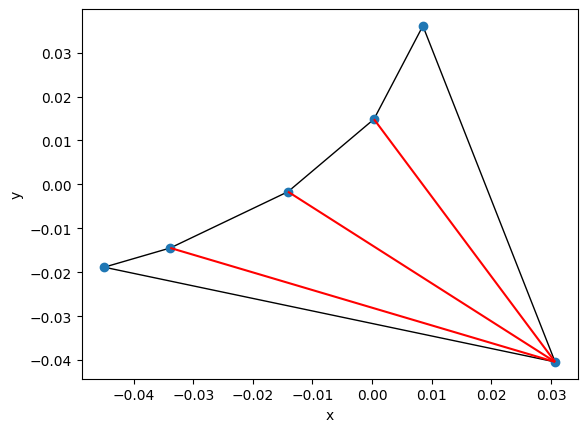

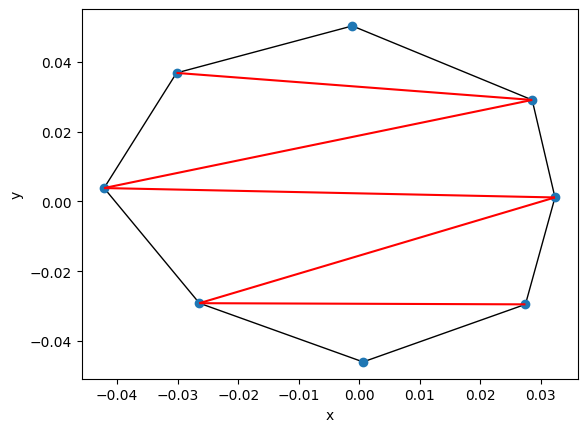

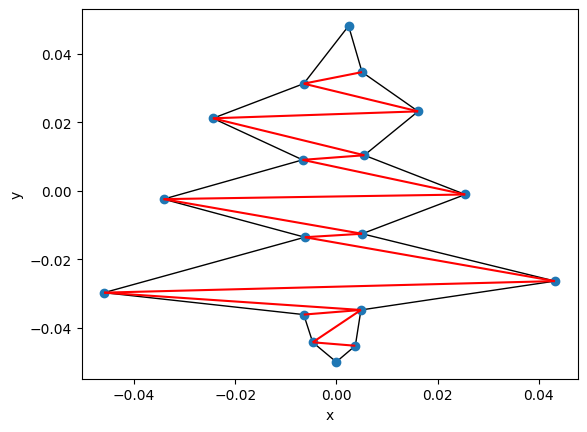

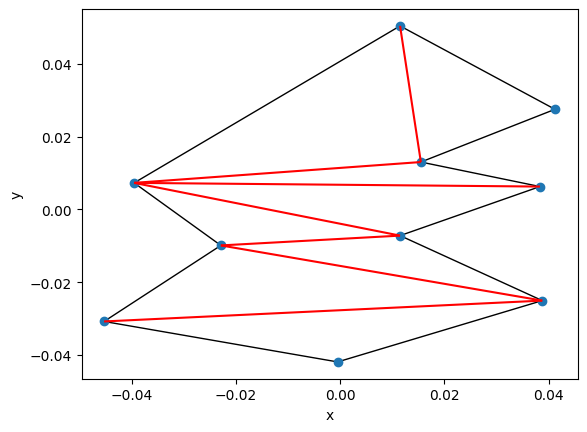

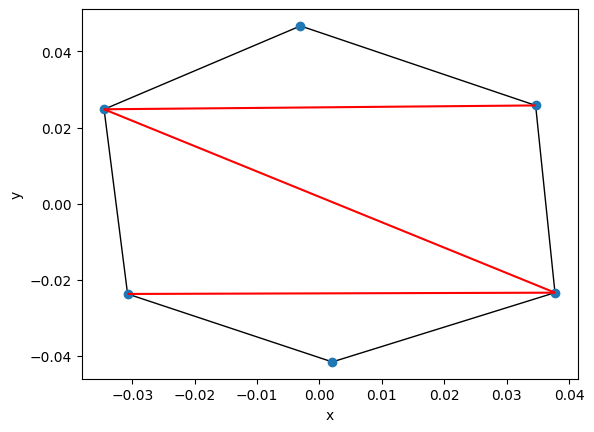

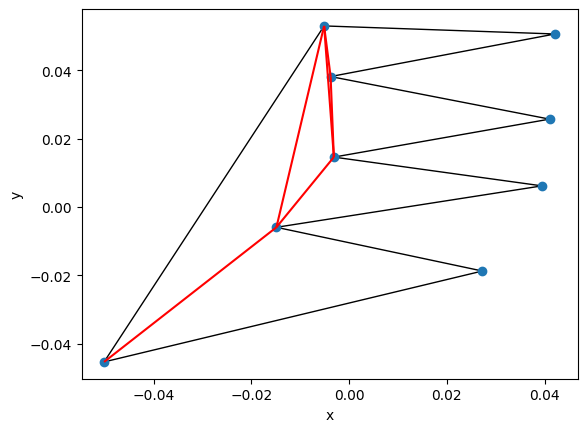

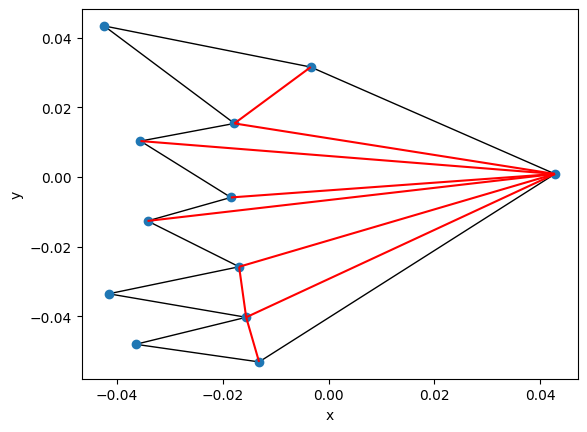

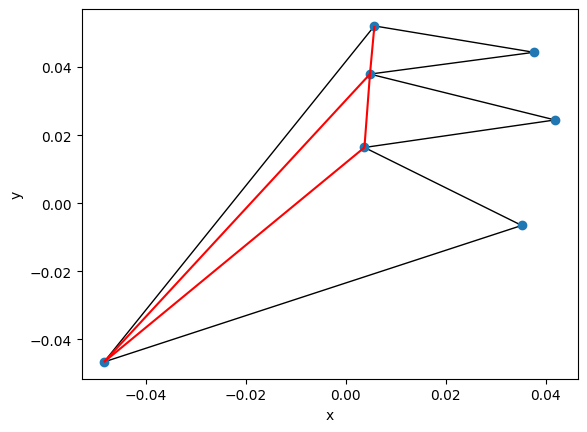

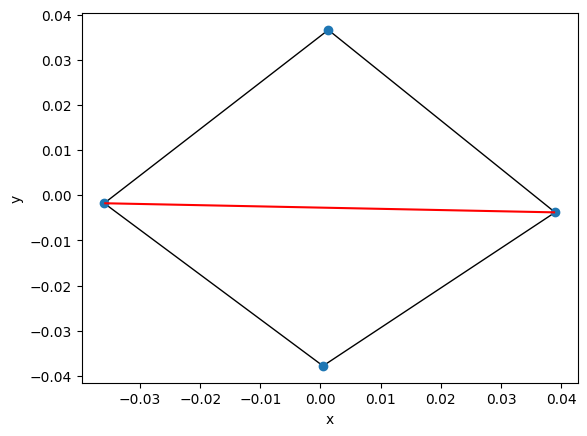

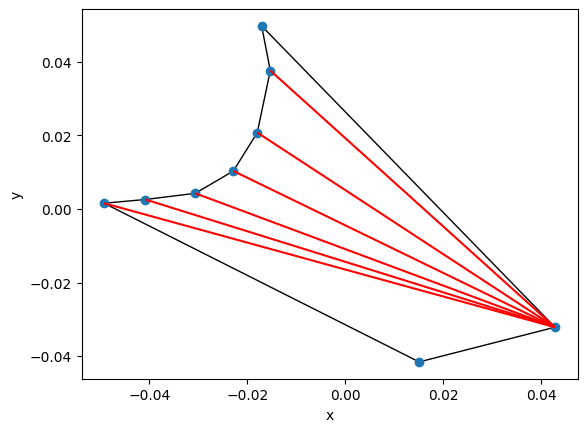

In [29]:
Test().runtest(3, triangulation)

Zwizualizuj powstały wielokąt podzielony na trójkąty.

In [30]:
# tri,vis = triangulation_draw(polygon_example_1)
# draw_polygon_tri(polygon_example_1,tri)
# vis.save_gif(filename="triangulation_gifs/example",interval=1)

In [31]:
# polygons = load_clicked_tests()
# for i in range(len(polygons)):
#     tri,vis = triangulation_draw(polygons[i])
#     draw_polygon_tri(polygons[i],tri)
#     vis.save_gif(filename=f"triangulation_gifs/example{i + 1}",interval=1)